2. 给 m 一定的权重
    * 如果不存在 m, 则 y=1
    * 如果存在1个 m, 则 y=0.9, m=0.1
    * 如果存在 2 个 m, 则 y=0.8, m1=0.1, m2=0.1
    * 如果存在 3 个 m, 则 y=0.7, m1=0.1, m2=0.1, m3=0.1

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入数据

In [3]:
# import os

# def mkdir_if_not_exist(path):
#     if not os.path.exists(os.path.join(*path)):
#         os.makedirs(os.path.join(*path))

# mkdir_if_not_exist(['./data/preprocessing'])

In [5]:
df_train = pd.read_csv('../../raw/base/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
1,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
2,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
3,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn
4,Images/collar_design_labels/fd01ac6593f254a5dd...,collar_design_labels,ynnnn


In [6]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [11]:
cur_class = classes[2]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

skirt_length_labels: 9223


,image_id,class,label
0,Images/skirt_length_labels/37cc74af47fb302a2d6...,skirt_length_labels,nnynnn
1,Images/skirt_length_labels/8753150147f1266120d...,skirt_length_labels,nnnnny
2,Images/skirt_length_labels/fd868bce2de45a0e4c7...,skirt_length_labels,nnnynn
3,Images/skirt_length_labels/448c9aa2cbafd2475d8...,skirt_length_labels,nnnymn
4,Images/skirt_length_labels/c4f87e3f6fdae6bc0bd...,skirt_length_labels,ynnnnn


## 切分训练/验证数据集

In [6]:
n_ration=0.9
valid_data=df_load[int(n_ration*len(df_load)):]
df_load=df_load[:int(n_ration*len(df_load))]

In [7]:
mkdir_if_not_exist(['./data/preprocessing/Images/{}/'.format(cur_class)])

## 数据预处理

In [11]:
rootdir = './data/train/Images/{}'.format(cur_class)  # 指明被遍历的文件夹
m = 0
outdir = './data/preprocessing/Images/{}/'.format(cur_class)

for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        currentPath = os.path.join(parent, filename)

        # 先填充, 再缩放
        img = cv2.imread(currentPath)
        dst0 = cv2.resize(img, (299, 299), interpolation=cv2.INTER_AREA)
        rows,cols,channels = dst0.shape

        # 顺时针旋转 5°/ 放大 5%
        M1 = cv2.getRotationMatrix2D((cols/2,rows/2),5,1) 
        M2 = cv2.getRotationMatrix2D((cols/2,rows/2),0,1.05) 
        dst1 = cv2.warpAffine(dst0,M1,(cols,rows))
        dst2 = cv2.warpAffine(dst0,M2,(cols,rows))
        
#         # 向下平移 0.2
#         M3 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst3 = cv2.warpAffine(dst0,M3,(cols,rows))
        
        # 水平翻转
        dst3 = cv2.flip(dst0, 1)
        
        # 高斯噪声
        dst0.astype("float")
        Gauss_noise = np.random.normal(3, 20, (rows, cols, channels))
        dst4 = dst0 + Gauss_noise
        dst4 = np.where(dst2 < 0, 0, np.where(dst4 > 255, 255, dst4))
        
#         # 对翻转后图片, 左右旋转 20°
#         M4 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
#         M5 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1)
#         dst5 = cv2.warpAffine(dst4,M4,(cols,rows))
#         dst6 = cv2.warpAffine(dst4,M5,(cols,rows))
        
#         # 翻转后向下平移 0.2
#         M6 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst7 = cv2.warpAffine(dst4,M6,(cols,rows))
        
        cv2.imwrite(outdir + filename + "-0.jpg", dst0)
        cv2.imwrite(outdir + filename + "-1.jpg", dst1)
        cv2.imwrite(outdir + filename + "-2.jpg", dst2)
        cv2.imwrite(outdir + filename + "-3.jpg", dst3)
        cv2.imwrite(outdir + filename + "-4.jpg", dst4.astype("uint8"))
#         cv2.imwrite(outdir + filename + "-5.jpg", dst5)
#         cv2.imwrite(outdir + filename + "-6.jpg", dst6)
#         cv2.imwrite(outdir + filename + "-7.jpg", dst7)
        m += 1
        if m%100 == 0:
            print('{} images have preprocessed.'.format(m))

100 images have preprocessed.
200 images have preprocessed.
300 images have preprocessed.
400 images have preprocessed.
500 images have preprocessed.
600 images have preprocessed.
700 images have preprocessed.
800 images have preprocessed.
900 images have preprocessed.
1000 images have preprocessed.
1100 images have preprocessed.
1200 images have preprocessed.
1300 images have preprocessed.
1400 images have preprocessed.
1500 images have preprocessed.
1600 images have preprocessed.
1700 images have preprocessed.
1800 images have preprocessed.
1900 images have preprocessed.
2000 images have preprocessed.
2100 images have preprocessed.
2200 images have preprocessed.
2300 images have preprocessed.
2400 images have preprocessed.
2500 images have preprocessed.
2600 images have preprocessed.
2700 images have preprocessed.
2800 images have preprocessed.
2900 images have preprocessed.
3000 images have preprocessed.
3100 images have preprocessed.
3200 images have preprocessed.
3300 images have 

## 加载训练集

In [12]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

In [9]:
X_train = np.zeros((n*3, width, width, 3), dtype=np.uint8)
y_train = np.zeros((n*3, n_class), dtype=np.uint8)

In [13]:
# 查看最多有多少个 m
max_m = []
for i in range(n):
    tmp_label = df_load['label'][i]
    m_num = tmp_label.count('m')
    max_m.append(m_num)
print(max(max_m))

1


In [11]:
def findStr(string, subStr, findCnt):
    listStr = string.split(subStr,findCnt)
    if len(listStr) <= findCnt:
        return -1
    return len(string)-len(listStr[-1])-len(subStr)

In [12]:
# label smooth
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    for j in range(3):
        X_train[i*3+j] = cv2.resize(cv2.imread('./data/preprocessing/{0}'.format(df_load['image_id'][i] + "-%s.jpg"%j)), (width, width))
        if tmp_label.count('m') == 1:
            y_train[i*3+j][tmp_label.find('y')] = 0.9
            y_train[i*3+j][tmp_label.find('m')] = 0.1
        elif tmp_label.count('m') == 2:
            y_train[i*3+j][tmp_label.find('y')] = 0.8
            y_train[i*3+j][tmp_label.find('m')] = 0.1    
            y_train[i*3+j][tmp_label.rfind('m')] = 0.1
        elif tmp_label.count('m') == 3:
            y_train[i*3+j][tmp_label.find('y')] = 0.7
            y_train[i*3+j][tmp_label.find('m')] = 0.1
            y_train[i*3+j][findStr(tmp_label, 'm', 2)] = 0.1
            y_train[i*3+j][tmp_label.rfind('m')] = 0.1
        else:
            y_train[i*3+j][tmp_label.find('y')] = 1

100%|██████████| 15556/15556 [01:38<00:00, 157.41it/s]


## 加载验证集

In [13]:
n_valid = len(valid_data)

X_valid = np.zeros((n_valid*3, width, width, 3), dtype=np.uint8)
y_valid = np.zeros((n_valid*3, n_class), dtype=np.uint8)

In [14]:
# 重置索引
valid_data = valid_data.reset_index(drop=True)

In [15]:
for i in tqdm(range(n_valid)):
    tmp_label = valid_data['label'][i]
    for j in range(3):
        X_valid[i*3+j] = cv2.resize(cv2.imread('./data/preprocessing/{0}'.format(valid_data['image_id'][i] + "-%s.jpg"%j)), (width, width))
        if tmp_label.count('m') == 1:
            y_valid[i*3+j][tmp_label.find('y')] = 0.6
            y_valid[i*3+j][tmp_label.find('m')] = 0.4
        elif tmp_label.count('m') == 2:
            y_valid[i*3+j][tmp_label.find('y')] = 0.4
            y_valid[i*3+j][tmp_label.find('m')] = 0.3    
            y_valid[i*3+j][tmp_label.rfind('m')] = 0.3
        elif tmp_label.count('m') == 2:
            y_valid[i*3+j][tmp_label.find('y')] = 0.4
            y_valid[i*3+j][tmp_label.find('m')] = 0.3    
            y_valid[i*3+j][tmp_label.rfind('m')] = 0.3
        elif tmp_label.count('m') == 3:
            y_valid[i*3+j][tmp_label.find('y')] = 0.4
            y_valid[i*3+j][tmp_label.find('m')] = 0.2 
            y_valid[i*3+j][findStr(tmp_label, 'm', 2)] = 0.2
            y_valid[i*3+j][tmp_label.rfind('m')] = 0.2
        else:
            y_valid[i*3+j][tmp_label.find('y')] = 1

100%|██████████| 1729/1729 [00:10<00:00, 166.72it/s]


In [16]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((46668, 299, 299, 3), (46668, 9), (5187, 299, 299, 3), (5187, 9))

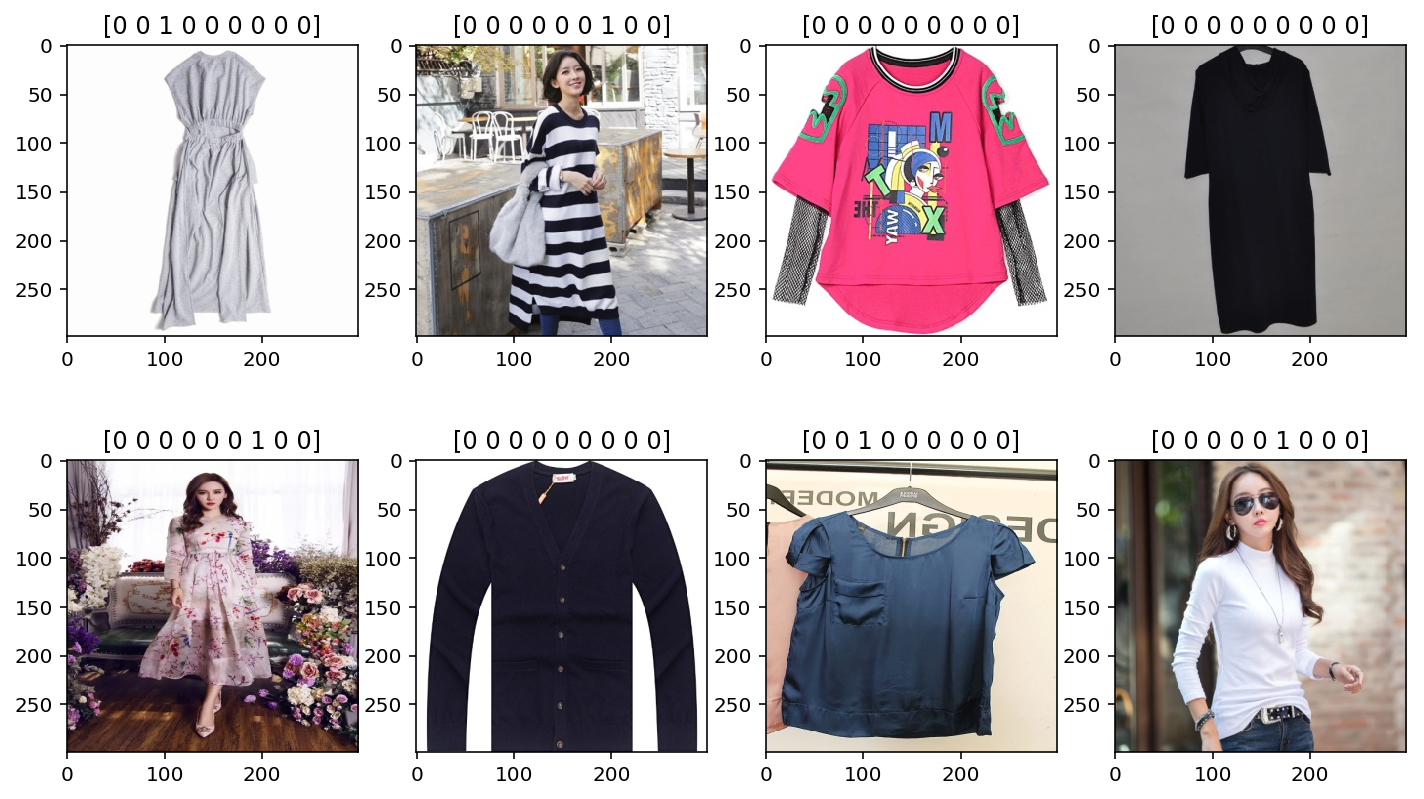

In [17]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[random_index][:,:,::-1])
    plt.title(y_train[random_index])

## 建立模型

In [18]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [19]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [20]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

In [24]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0513a_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 46668 samples, validate on 5187 samples
Epoch 1/1
46668/46668 [==============================] - 1579s 34ms/step - loss: 1.1062 - acc: 0.4172 - val_loss: 0.9578 - val_acc: 0.4851

Epoch 00001: val_loss improved from inf to 0.95777, saving model to ./models/sleeve.best0513a_InceptionResNetV2.h5


In [21]:
model.load_weights('./models/{}.best0513a_InceptionResNetV2.h5'.format(prefix_cls))

In [22]:
# 学习率减小 50 倍
adam = Adam(lr=0.00002)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0513a_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 46668 samples, validate on 5187 samples
Epoch 1/1
46668/46668 [==============================] - 1587s 34ms/step - loss: 0.7149 - acc: 0.5699 - val_loss: 0.7849 - val_acc: 0.5487

Epoch 00001: val_loss improved from inf to 0.78493, saving model to ./models/sleeve.best0513a_InceptionResNetV2.h5


In [56]:
# 测试模型
# model.evaluate(X_valid, y_valid, batch_size=256)

## 模型测试

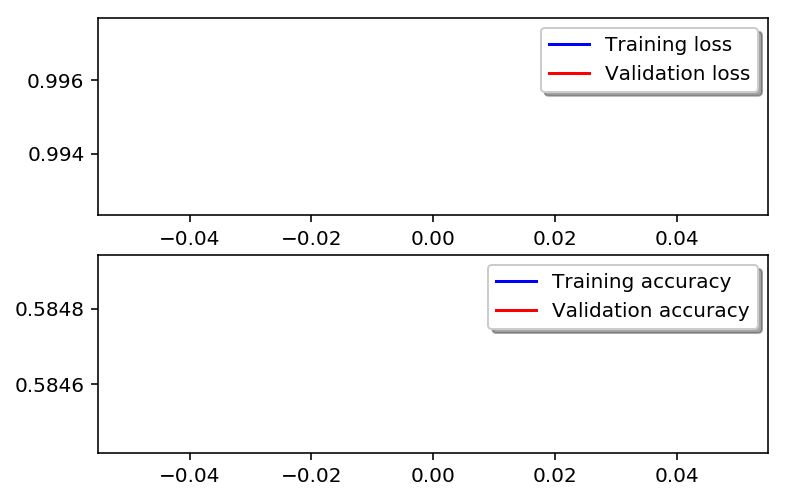

In [26]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(h.history['loss'], color='b', label="Training loss")
ax[0].plot(h.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(h.history['acc'], color='b', label="Training accuracy")
ax[1].plot(h.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 混淆矩阵

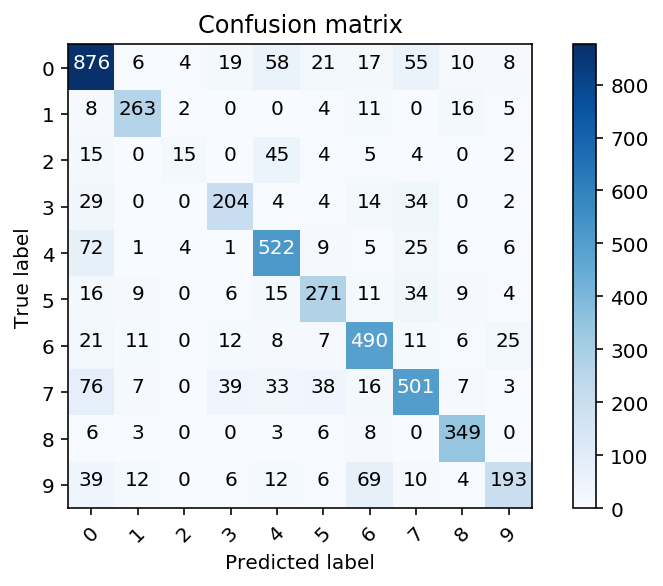

In [95]:
## Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plt the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(n_class))

## 测试集数据预处理

In [29]:
mkdir_if_not_exist(['./data/test-preprocessing/Images/{}/'.format(cur_class)])

In [30]:
rootdir = './data/week-rank/Images/{}'.format(cur_class)  # 指明被遍历的文件夹
m = 0
outdir = './data/test-preprocessing/Images/{}/'.format(cur_class)

for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        currentPath = os.path.join(parent, filename)

        # 先填充, 再缩放
        img = cv2.imread(currentPath)
        dst0 = cv2.resize(img, (299, 299), interpolation=cv2.INTER_AREA)
        rows,cols,channels = dst0.shape

        # 顺时针旋转 5°/ 放大 5%
        M1 = cv2.getRotationMatrix2D((cols/2,rows/2),5,1) 
        M2 = cv2.getRotationMatrix2D((cols/2,rows/2),0,1.05) 
        dst1 = cv2.warpAffine(dst0,M1,(cols,rows))
        dst2 = cv2.warpAffine(dst0,M2,(cols,rows))
        
#         # 向下平移 0.2
#         M3 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst3 = cv2.warpAffine(dst0,M3,(cols,rows))
        
        # 水平翻转
        dst3 = cv2.flip(dst0, 1)
        
        # 高斯噪声
        dst0.astype("float")
        Gauss_noise = np.random.normal(3, 20, (rows, cols, channels))
        dst4 = dst0 + Gauss_noise
        dst4 = np.where(dst2 < 0, 0, np.where(dst4 > 255, 255, dst4))
        
#         # 对翻转后图片, 左右旋转 20°
#         M4 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
#         M5 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1)
#         dst5 = cv2.warpAffine(dst4,M4,(cols,rows))
#         dst6 = cv2.warpAffine(dst4,M5,(cols,rows))
        
#         # 翻转后向下平移 0.2
#         M6 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst7 = cv2.warpAffine(dst4,M6,(cols,rows))
        
        cv2.imwrite(outdir + filename + "-0.jpg", dst0)
        cv2.imwrite(outdir + filename + "-1.jpg", dst1)
        cv2.imwrite(outdir + filename + "-2.jpg", dst2)
        cv2.imwrite(outdir + filename + "-3.jpg", dst3)
        cv2.imwrite(outdir + filename + "-4.jpg", dst4.astype("uint8"))
#         cv2.imwrite(outdir + filename + "-5.jpg", dst5)
#         cv2.imwrite(outdir + filename + "-6.jpg", dst6)
#         cv2.imwrite(outdir + filename + "-7.jpg", dst7)
        m += 1
        if m%100 == 0:
            print('{} images have preprocessed.'.format(m))

100 images have preprocessed.
200 images have preprocessed.
300 images have preprocessed.
400 images have preprocessed.
500 images have preprocessed.
600 images have preprocessed.
700 images have preprocessed.
800 images have preprocessed.
900 images have preprocessed.
1000 images have preprocessed.
1100 images have preprocessed.
1200 images have preprocessed.
1300 images have preprocessed.
1400 images have preprocessed.
1500 images have preprocessed.


## 预处理图片进行全部预测

In [24]:
df_test = pd.read_csv('./data/week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [25]:
df_load2 = df_test[(df_test['class'] == cur_class)].copy()
df_load2.reset_index(inplace=True)
del df_load2['index']

print('{0}: {1}'.format(cur_class, len(df_load2)))
df_load2.head()

sleeve_length_labels: 2895


,image_id,class
0,Images/sleeve_length_labels/3a59bdc48834d4578e...,sleeve_length_labels
1,Images/sleeve_length_labels/a12e001f27c07365e6...,sleeve_length_labels
2,Images/sleeve_length_labels/ba5c56b7bc61711db3...,sleeve_length_labels
3,Images/sleeve_length_labels/efd82f9d354c0b2d53...,sleeve_length_labels
4,Images/sleeve_length_labels/1283a0ff4560bba965...,sleeve_length_labels


In [26]:
n = len(df_load2)
width = 299 # 定义图片大小
X_test = np.zeros((n*3, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    for j in range(3):
        X_test[i*3+j] = cv2.resize(cv2.imread('./data/test-preprocessing/{0}'.format(df_load2['image_id'][i] + "-%s.jpg"%j)), (width, width))

100%|██████████| 2895/2895 [00:18<00:00, 159.20it/s]


In [27]:
# model.load_weights('./models/{}.best0511_InceptionResNetV2.h5'.format(prefix_cls))

In [28]:
test_np = model.predict(X_test, batch_size=256)

In [29]:
# 取同一张图片不同预处理方式的平均值
result = []

for i, row in df_load2.iterrows():
    tmp_list = (test_np[i*3+0] + test_np[i*3+1] + test_np[i*3+2])/3
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load2['result'] = result
df_load2.head()

,image_id,class,result
0,Images/sleeve_length_labels/3a59bdc48834d4578e...,sleeve_length_labels,0.0009;0.2859;0.0002;0.0003;0.0562;0.6532;0.00...
1,Images/sleeve_length_labels/a12e001f27c07365e6...,sleeve_length_labels,0.0001;0.0003;0.0000;0.0007;0.0248;0.4965;0.36...
2,Images/sleeve_length_labels/ba5c56b7bc61711db3...,sleeve_length_labels,0.0001;0.0704;0.0010;0.0003;0.0346;0.8926;0.00...
3,Images/sleeve_length_labels/efd82f9d354c0b2d53...,sleeve_length_labels,0.0123;0.0002;0.0001;0.0000;0.0160;0.9598;0.00...
4,Images/sleeve_length_labels/1283a0ff4560bba965...,sleeve_length_labels,0.0000;0.0007;0.7207;0.2782;0.0003;0.0000;0.00...


In [30]:
df_load2.to_csv('./result/{}_0513a_InceptionResNetV2.csv'.format(prefix_cls), header=None, index=False)